In [1]:
import sys
import os
import time
import argparse
import math
import resource
import multiprocessing as mp

import numpy as n
import numpy.fft as fourier

sys.path.append('cryoem/')
sys.path.append('cryoem/util')

from cryoem.cryoio import ctf
from cryoem.cryoio import mrc
from cryoem.util import format_timedelta
from cryoem import cryoem
from cryoem import geom
from cryoem import cryoops
from cryoem import density
from cryoem import sincint

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# For parallel https://stackoverflow.com/questions/15639779/why-does-multiprocessing-use-only-a-single-core-after-i-import-numpy
os.environ["OPENBLAS_MAIN_FREE"] = "1"

# Set the files open limit (must exceed the simulation chunk size)
resource.setrlimit(resource.RLIMIT_NOFILE, (1100, 1100))

# matplotlib configuration
mpl.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

In [12]:
# setup microscope and ctf parameters
params = {}
params['defocus_min'] = 10000
params['defocus_max'] = 20000
params['defocus_ang_min'] = 0
params['defocus_ang_max'] = 360
params['accel_kv'] = 300
params['amp_contrast'] = 0.07
params['phase_shift'] = 0
params['spherical_abberr'] = 2.7
params['mag'] = 10000.0
scale = 1

# particle parameters
params['n_particles'] = args.n_particles

params['snr'] = 0.05

if args.snr is not None:
    params['snr'] = args.snr

# miscellaneous parameters
params['kernel'] = 'lanczos'
params['ksize'] = int(6)
params['rad'] = 0.95
params['shift_sigma'] = 0
params['bfactor'] = 50.0

# Read the volume data and compute fft
vol,hdr = mrc.readMRC(args.input, inc_header=True)

params['boxSize'] = int(vol.shape[0])
params['pxSize'] = (hdr['xlen']/hdr['nx'])

premult = cryoops.compute_premultiplier(params['boxSize'], params['kernel'], params['ksize']) 

V = density.real_to_fspace(premult.reshape((1,1,-1)) * premult.reshape((1,-1,1)) * premult.reshape((-1,1,1)) * vol)

params['sigma_noise'] = vol.std()/params['snr']

if args.sigma_noise is not None:
    params['sigma_noise'] = args.sigma_noise
    print('Using user-specified sigma_noise.')

print('Noise Sigma: ' + str(params['sigma_noise']))

# Set up the particles datastructures
particles = n.empty((params['n_particles'], params['boxSize'], params['boxSize']), dtype=density.real_t)
starfile = []
TtoF = sincint.gentrunctofull(N=params['boxSize'], rad=params['rad'])

tic = time.time()

results = []

nChunks = math.ceil(params['n_particles'] / 1000)
lastChunkSize = params['n_particles'] - ((nChunks - 1)*1000)

for i in range(nChunks):
    ticc = time.time()
    if i == nChunks - 1:
        chunkSize = lastChunkSize
    else:
        chunkSize = 1000

    # PROCESS IMPLEMENTATION
    manager = mp.Manager()
    output = manager.list()

    jobs = []
    concurrency = mp.cpu_count() - 1

    if args.cpus is not None:
        concurrency = args.cpus

    sema = mp.Semaphore(concurrency)

    print("\nSimulating %d particles on %d processors." % (params['n_particles'], concurrency))

    for j in range(chunkSize):
        idx = i * chunkSize + j
        sema.acquire()
        p = mp.Process(target=simulateParticle, args=(output, params, V, TtoF, idx, tic, sema))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()

    results.extend(output)

    print("\nDone simulating stack %d of size %d in time %s." % (i, chunkSize, format_timedelta(time.time() - ticc)))

print("\nDone simulating all particles in: %s" % format_timedelta(time.time() - tic))

results = sorted(results, key=lambda x: x[0])

particles = [result[1] for result in results]
starfile = [result[2] for result in results]

print('\nWriting out data...')

# Plot the first 8 images
fig = plt.figure(figsize=(12, 5))
col = 4
row = 2
for i in range(1, col*row +1):
    img = particles[i]
    fig.add_subplot(row, col, i)
    plt.imshow(img, cmap='gray')
plt.savefig(args.output_path + 'plot.png')

mrc.writeMRC(args.output_path + 'simulated_particles.mrcs', n.transpose(particles,(1,2,0)), params['pxSize'])

# Write the starfile
f = open((args.output_path + 'simulated_particles.star'), 'w')
# Write the header
f.write("\ndata_iparams['mag']es\n\nloop_\n_rlnAmplitudeContrast #1 \n_rlnAnglePsi #2 \n_rlnAngleRot #3 \n_rlnAngleTilt #4 \n_rlnClassNumber #5 \n_rlnDefocusAngle #6 \n_rlnDefocusU #7 \n_rlnDefocusV #8 \n_rlnDetectorPixelSize #9 \n_rlnImageName #10 \n_rlnMagnification #11 \n_rlnOriginX #12 \n_rlnOriginY #13 \n_rlnPhaseShift #14 \n_rlnSphericalAberration #15\n_rlnVoltage #16\n\n")
# Write the particle information
for l in starfile:
    f.write(' '.join(l) + '\n')
f.close()
print('Done!')

In [13]:
# Read the volume data and compute fft
vol,hdr = mrc.readMRC("test_data/6ac9TeMet_denmod_bigbox.mrc", inc_header=True)
# vol,hdr = mrc.readMRC("test_data/6ac9TeMet_denmod.mrc", inc_header=True)

boxSize = int(vol.shape[0])
pxSize = (hdr['xlen']/hdr['nx'])

premult = cryoops.compute_premultiplier(boxSize, kernel, ksize) 

V = density.real_to_fspace(premult.reshape((1,1,-1)) * premult.reshape((1,-1,1)) * premult.reshape((-1,1,1)) * vol)

vol_f = fourier.fftshift(fourier.fft2(vol))

# plt.imshow(n.abs(testF), norm=LogNorm(vmin=5))
sigma_noise = vol.std()/snr
print('Noise sigma: ' + str(sigma_noise))

Noise sigma: 3.059394657611847


In [14]:
particle_metadata = [{} for _ in range(n_particles)]
particles = n.empty((n_particles, boxSize, boxSize), dtype=density.real_t)
starfile = []
TtoF = sincint.gentrunctofull(N=boxSize, rad=rad)

tic = time.time()
for i,p in enumerate(particle_metadata):
    ellapse_time = time.time() - tic
    remain_time = float(n_particles - i)*ellapse_time/max(i,1)
    print("\r%.2f Percent Complete (%d particles done)... (Elapsed: %s, Remaining: %s)" % (i/float(n_particles)*100.0,i,format_timedelta(ellapse_time),format_timedelta(remain_time)), end="")
    
    # GENERATE PARTICLE ORIENTATION AND CTF PARAMETERS
    # Random orientation vector and get spherical angles
    pt = n.random.randn(3)
    pt /= n.linalg.norm(pt)
    psi = 2*n.pi*n.random.rand()
    
    # Compute Euler angles from a direction vector. Output EA is tuple with phi, theta, psi.
    EA = geom.genEA(pt)[0]
    EA[2] = psi
    
    p['phi'] = EA[0]*180.0/n.pi
    p['theta'] = EA[1]*180.0/n.pi
    p['psi'] = EA[2]*180.0/n.pi
    
    # Compute a random shift
    shift = n.random.randn(2) * shift_sigma
    p['shift_x'] = shift[0]
    p['shift_y'] = shift[1]
    
    # Random defocus within the ranges
    base_defocus = n.random.uniform(defocus_min, defocus_max)
    p['defocus_a'] = base_defocus + n.random.uniform(-500,500)
    p['defocus_b'] = base_defocus + n.random.uniform(-500,500)
    p['astig_angle'] = n.random.uniform(defocus_ang_min, defocus_ang_max)
    
    # CREATE THE PROJECTIONS AND APPLY CTFS
    # Generate rotation matrix based on the Euler Angles
    R = geom.rotmat3D_EA(*EA)[:,0:2]
    slop = cryoops.compute_projection_matrix([R], boxSize, kernel, ksize, rad, 'rots')
    S = cryoops.compute_shift_phases(shift.reshape((1,2)), boxSize, rad)[0]
    D = slop.dot(V.reshape((-1,)))
    D *= S
      
    # Generate the CTF
    C = ctf.compute_full_ctf(None, boxSize, pxSize, accel_kv, spherical_abberr, amp_contrast, p['defocus_a'], p['defocus_b'], n.radians(p['astig_angle']), 1, bfactor)

    # Apply CTF to the projection and write to particles array
    ctf_distorted = density.fspace_to_real((C*TtoF.dot(D)).reshape((boxSize,boxSize)))
    noise_added = ctf_distorted + n.require(n.random.randn(boxSize, boxSize)*sigma_noise,dtype=density.real_t)
    particles[i] = -noise_added
    
    starfile_line = [str(amp_contrast), 
                     str(p['psi']), 
                     str(p['phi']), 
                     str(p['theta']),
                     str(1),
                     str(p['astig_angle']),                     
                     str(p['defocus_a']),
                     str(p['defocus_b']),
                     str(pxSize),
                     "%d@/simulated_particles.mrcs" % (i+1),
                     str(mag),
                     str(0),
                     str(0),
                     str(0),
                     str(spherical_abberr),
                     str(accel_kv)]
    starfile.append(starfile_line)
                          

87.50 Percent Complete (7 particles done)... (Elapsed: 00:00:01s, Remaining: 00:00:00s)

IndexError: index 8 is out of bounds for axis 0 with size 8

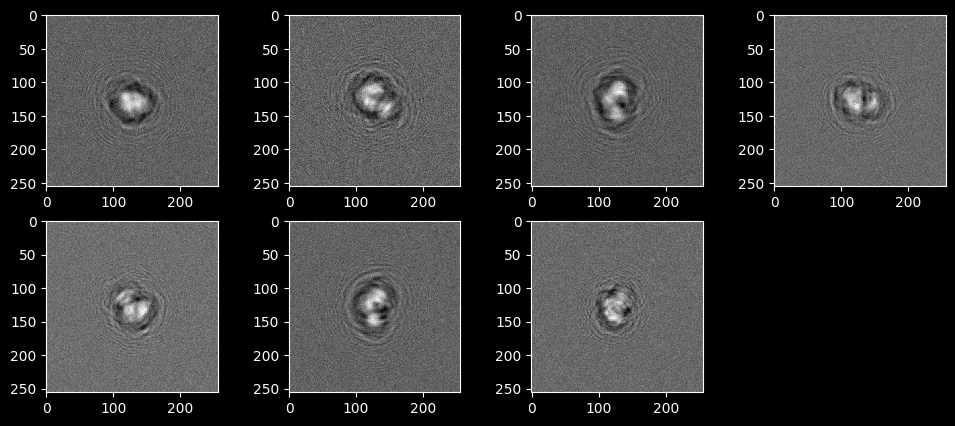

In [15]:
# Plot the first 8 images
fig = plt.figure(figsize=(12, 5))
col = 4
row = 2
for i in range(1, col*row +1):
    img = particles[i]
    fig.add_subplot(row, col, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [60]:
# Write the particle stack
mrc.writeMRC('output/simulated_particles.mrcs', n.transpose(particles,(1,2,0)), pxSize)

In [61]:
# Write the starfile
f = open('output/simulated_particles.star', 'w')
# Write the header
f.write("\ndata_images\n\nloop_\n_rlnAmplitudeContrast #1 \n_rlnAnglePsi #2 \n_rlnAngleRot #3 \n_rlnAngleTilt #4 \n_rlnClassNumber #5 \n_rlnDefocusAngle #6 \n_rlnDefocusU #7 \n_rlnDefocusV #8 \n_rlnDetectorPixelSize #9 \n_rlnImageName #10 \n_rlnMagnification #11 \n_rlnOriginX #12 \n_rlnOriginY #13 \n_rlnPhaseShift #14 \n_rlnSphericalAberration #15\n_rlnVoltage #16\n\n")
# Write the particle information
for l in starfile:
    f.write(' '.join(l) + '\n')
f.close()